In [1]:
import numpy as np
from vowpalwabbit import pyvw
from newsenv import rand_simple_news_3
import random
import matplotlib.pyplot as plt
import pandas as pd
from ips_snips import Estimator

In [2]:
def to_vw_example_format(context, actions, cb_label = None):
    if cb_label is not None:
        chosen_action, cost, prob = cb_label
    example_string = ""
    example_string += "shared |User user={}\n".format(context["user"])
    for action in actions:
        if cb_label is not None and action == chosen_action:
            example_string += "0:{}:{} ".format(cost, prob)
        example_string += "|Action article={} \n".format(action)
    #Strip the last newline
    return example_string[:-1]

In [3]:
def get_action(vw, context, actions):
    vw_text_example = to_vw_example_format(context,actions)    
    pmf = vw.predict(vw_text_example)
    pmf=np.array(pmf)
    pmf=pmf/sum(pmf)
    chosen_action_index=np.random.choice(np.arange(len(actions)),p=pmf)    
    return chosen_action_index

In [4]:
def train_offline(env,vw,input_df,actions,epsilon):
    t_cost_sum = 0. #Training Algo
    t_ctr=[]   
    o_cost_sum=0.   #Optimal Algo
    o_ctr=[]    
   
    for i in range(len(input_df)):
        action = input_df.loc[i, "action"]
        cost = input_df.loc[i, "cost"]
        prob = input_df.loc[i, "prob"]
        user = input_df.loc[i, "user"]        
        tod = input_df.loc[i, "tod"]
        context={"user":user,"tod":tod}                    
        vw_format = vw.parse(to_vw_example_format(context, actions, (action, cost, prob)),pyvw.vw.lContextualBandit)            
        vw.learn(vw_format)
        vw.finish_example(vw_format)
        
        t_action=get_action(vw, context, actions) #Take action according to current policy in learning 
        t_cost = env.get_cost(context, t_action)  #Get cost on the policy currently being learnt 
        t_cost_sum += t_cost
        t_ctr.append(-1*t_cost)
#         t_ctr.append(-1*t_cost_sum/(i+1))        
       
        
        o_action=env.get_e_optimal_action(context,epsilon) #Obtain the optimal action to be taken 
        o_cost=env.get_cost(context,o_action)
        o_cost_sum+=o_cost
        o_ctr.append(-1*o_cost)
#         o_ctr.append(-1*o_cost_sum/(i+1))  #Collect the cost of the optimal action

    return vw,t_ctr,o_ctr,t_cost_sum,o_cost_sum

In [5]:
def plot_ctr(num_iterations,t_ctr,o_ctr,minP,maxP):
    plt.plot(range(1,num_iterations+1), t_ctr,'--r',label='Offline Learnt Algo')    
    plt.plot(range(1,num_iterations+1), o_ctr,'--k',label='Optimal Algo')
    plt.xlabel('num_iterations', fontsize=14)
    plt.ylabel('ctr', fontsize=14)
    plt_lim=0.2
    plt.ylim([minP*(1-plt_lim),maxP*(1+plt_lim)])
    plt.legend()
    plt.grid()
    plt.show()

In [6]:
def eval_off_pol(agent,input_df,actions):
    est=Estimator()
    for i in range(len(input_df)):
        action_log = input_df.loc[i, "action"]
        cost = input_df.loc[i, "cost"]
        prob_log = input_df.loc[i, "prob"]
        user = input_df.loc[i, "user"]        
        tod = input_df.loc[i, "tod"]
        context={"user":user,"tod":tod}
        vw_text_example = to_vw_example_format(context,actions)    
        pmf = agent.predict(vw_text_example)
        pmf=np.array(pmf)
        pmf=pmf/sum(pmf)
        prob_pred=pmf[int(action_log)]
        est.add_example(prob_log,-1*cost,prob_pred)
    print('IPS estimate: ',est.get_estimate('ips'))
    print('SNIPS estimate: ',est.get_estimate('snips'))
    print('Clopper-Pearson confidence intervals ', est.get_interval('clopper-pearson'))
    print('Gaussian confidence intervals ',est.get_interval('gaussian'))
    

In [7]:
def get_avg(array,N=30000):
    cumsum, moving_aves = [0], []
    for i, x in enumerate(array, 1):
        cumsum.append(cumsum[i-1] + x)
        if i>=N:
            moving_ave = (cumsum[i] - cumsum[i-N])/N           
        else:
            moving_ave=cumsum[i]/i
        
        moving_aves.append(moving_ave)
            
    return moving_aves

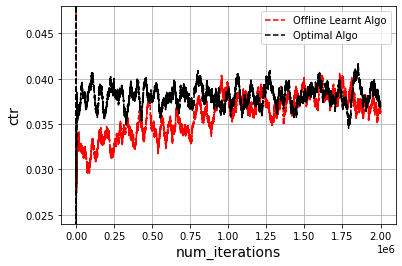

Algorithm total reward: 72117.0 Optimal total reward: 76199.0
IPS estimate:  0.03721412452558278
SNIPS estimate:  0.03718865789087133
Clopper-Pearson confidence intervals  [0.035551715997774395, 0.038931891883958625]
Gaussian confidence intervals  [0.036293218933025104, 0.038135030118140456]


In [8]:
input_df=pd.read_csv('Testdata.csv')
interest_df=pd.read_csv('Interest.csv')
num_user=10
num_action=10
maxP=0.04
minP=0.03
actions = [i for i in range(num_action)]
eps=0.2
env=rand_simple_news_3(num_user,num_action,maxP,minP)
env.interest=np.array([int(interest_df.loc[i, "Interest"]) for i in range(len(interest_df))])
vw = pyvw.vw("--cb_explore_adf -q UA --coin --quiet --clip_p 0.1 --epsilon "+str(eps))
agent,t_ctr_1,o_ctr_1,t_cost_sum,o_cost_sum=train_offline(env,vw,input_df,actions,eps)
t_ctr=get_avg(t_ctr_1)
o_ctr=get_avg(o_ctr_1)
num_iterations=len(t_ctr)
plot_ctr(num_iterations,t_ctr,o_ctr,minP,maxP)
print('Algorithm total reward: '+str(-1*t_cost_sum)+' Optimal total reward: ' +str(-1*o_cost_sum))
eval_off_pol(agent,input_df,actions)